## Pytorch 101 - Introduction - Image Classification with Cifar10

<img src="../nb_images/pytorch.png" alt="Drawing" style="width: 400px;"/>

The goal of this lab is to introduce you to **image classification with PyTorch using the Torchvision library**, and to also show you how to visualize whats happening with different layers of the neural network.  

To do this , we will train a simple convolutional neural network with the CIFAR-10 dataset, and plot some interesting visualizations of what is happening internally.  You can re-use this pattern on other networks once you see how easy it is to classify images and extract feature maps.  

As an optional lab, we will demonstrate how to use **transfer learning** to accelerate and improve your training tasks.

Lets get started!



In [ ]:
# default_exp pytorch_cifar

### Data Overview

For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

MNIST digit classification dataset (50K hand written digits) has typically been used in the past to teach neural networks, but MNIST for all intents and purposes is a dataset that is too "easy" for deep learning neural networks.  Researchers recommend starting with a slightly harder examples to train your introductory networks.  Datasets like CIFAR or Fashion MNIST are good choices to test our neural network architectures and also to learn about the frameworks.  Here we use the CIFAR10 dataset as shown below

### Definitions
* Tensor - an N dimensional array of data.  E.g a matrix is a 2D tensor


## CIFAR10 Dataset
<img src="https://pytorch.org/tutorials/_images/cifar10.png" style="width: 700px;" />



### Imports

In [1]:
# export
# Some good references
# https://github.com/zalandoresearch/fashion-mnist
# https://pytorch.org/docs/stable/torchvision/datasets.html#mnist
# http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/#  <- performance results!

import torch
import numpy as np
import torch.optim as optim
from torch.nn.init import xavier_normal_ , uniform_
from torchvision.utils import make_grid
# import utils   # custom functions for this notebook
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import utils



In [2]:
# Notebook only libs
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output

%matplotlib inline



<!-- This is commented out. 
### Cell used for debug

!pwd
!which python
!which jupyter

def reload_libs() :
    %load_ext autoreload
    %autoreload 2
    import utils
    
    
    
<details>
<summary>Hint</summary>
<p> Insert answer here ... </p></details>

-->

## Import Dataset from web

Here we download the dataset from the web.  Torch comes with the handy __[torchvision](https://pytorch.org/docs/stable/torchvision/index.html#module-torchvision)__  library that includes datasets and commonly used [image transformers](https://pytorch.org/docs/stable/torchvision/transforms.html).   


In [3]:
# export
# Grab the data
xt = transforms.Compose([
     transforms.RandomRotation(30, resample=False, expand=False, center=None),
     transforms.ToTensor(),
])

xt_test = transforms.Compose([
     transforms.ToTensor(),
])

#torchvision.datasets.CIFAR10(root, train=True, transform=None, target_transform=None, download=False)

#transform=transforms.ToTensor()
train_set = dset.CIFAR10(root = './cifar10_data', 
                                 download=True, transform=xt)

test_set = dset.CIFAR10(root='./cifar10_data', train=False, 
                         download=True, transform=xt_test) #transform=trans



0it [00:00, ?it/s]

170500096it [00:02, 68916308.57it/s]                               


Extracting ./cifar10_data/cifar-10-python.tar.gz to ./cifar10_data
Files already downloaded and verified


In [4]:
!ls ./cifar10_data/cifar-10-batches-py/data_batch_1

./cifar10_data/cifar-10-batches-py/data_batch_1


Torchvision also provides utilities to read in datasets.  This will be useful during our training sessions where we will iterate through batches of images.   Notice, this is where we set the batch size for the rest of the training.

In [5]:
# export
batch_size = 64

# https://pytorch.org/docs/stable/data.html
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)


print('Number of Training samples: ', len(train_set))
print('Number of Test samples: ',     len(test_set))
print('Batch Size : ',                batch_size)
print('==>>> total training batches : {}'.format(len(train_loader)))
print('==>>> total testing batches : {}'.format(len(test_loader)))
#print('type {}'.format(type(train_fm_loader)))


Number of Training samples:  50000
Number of Test samples:  10000
Batch Size :  64
==>>> total training batches : 782
==>>> total testing batches : 157


### Explore the data set
If we take a look an example of a 'loader' tensor, you will see that its a 4 D tensor of the following format
* (batch, channel, height , width)

Showing details about the first batch in the training set (train_loader).  Note the size of the tensor.  Can you figure out what each dimension represents?

<details>
<summary>Answer</summary>
<p> Below we read out  the first batch from the train loader data structure to inspect.  We want to make sure the batch is 16, the number of channels is 3 (RGB), and the height and width are 32. </p></details>



In [6]:
# Quick test ....
for i, (images, labels) in enumerate(train_loader):
    print("Image Tensor Dimensions = {}\n\nLabel Tensor Dimensions = {}\n\nSample Labels = \n{}".format(images.size(), labels.size(), labels))
    print()
    #print(i,images.size(), labels.size(), labels)
    if(i==0):
        break

Image Tensor Dimensions = torch.Size([64, 3, 32, 32])

Label Tensor Dimensions = torch.Size([64])

Sample Labels = 
tensor([7, 8, 4, 6, 2, 2, 0, 0, 3, 0, 4, 1, 0, 4, 9, 2, 9, 8, 1, 0, 7, 3, 1, 3,
        5, 1, 1, 7, 1, 0, 7, 5, 5, 5, 4, 1, 2, 4, 7, 2, 7, 1, 8, 3, 8, 4, 9, 3,
        2, 5, 7, 9, 4, 8, 8, 2, 0, 3, 9, 2, 7, 1, 8, 1])



### Lookup table for the CIFAR10 dataset
If you notice above the labels tensor is just a bunch of numbers 0-9.  You can index into the dictionary below to see what the labels mean.

Labels 0-9 mapping

In [14]:
# export
labels_map = {
    0:"plane",
    1:"car",
    2:"bird",
    3:"cat",
    4:"deer",
    5:"dog",
    6:"frog",
    7:"horse",
    8:"ship",
    9:"truck"
}


## Visualize a single image .....

Now its time to see what our CIFAR 10 images look like, and just spot check to make sure we have the proper labels

Here is a quick utility to plot an image.   Change the IMG value to convince yourself that we have the right labels.

torch.Size([32, 32, 3])
bird


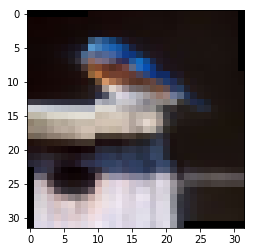

In [8]:
#https://pillow.readthedocs.io/en/5.3.x/
def plot_image(pil_image) :  
    print(pil_image.shape)
    plt.imshow(pil_image)


IMG=13
plot_image(train_set[IMG][0].permute(1,2,0))
print(labels_map[train_set[IMG][1]])

### Visualize a grid of images
Torchvision also comes with a routine to help you plot a whole NxN grid of images.  Lets see how to do this ..
First we setup a few helper functions.  

get_batch : used to fetch a single batch of images from our dataset .  Will return the number of images based on the batch size defined above

show : used for plotting our image grid

In [9]:
# Helper functions 

# Grab a specfic batch from a data_loader object
def get_batch(data_loader, batchnum) :
    batch = next(iter(data_loader))[0]
    for i in range(batchnum) :
        batch = next(iter(data_loader))[0]
    return batch

# plt.imshow wrapper that takes a list or pytorch tensor, and converts to numpy array
# performs a simple permutation of indexes C,H,W --> H,W,C
def show(img):
    npimg = img.numpy()
    fig, ax1 = plt.subplots(figsize=(11, 11))
    ax1.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest',)

### make_grid utility example
* read in a batch of images
* plot the batch using make_grid and plt.imshow routines

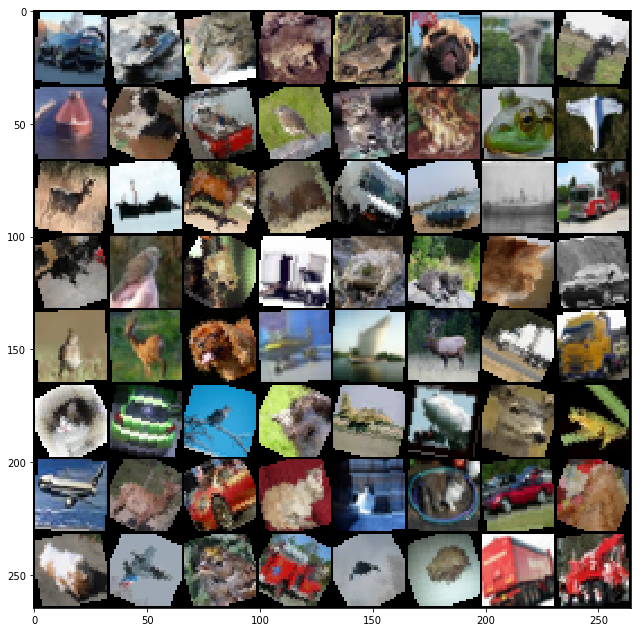

In [10]:
# Grab a batch of 64 images ...
image_tensor = get_batch(train_loader, 1)

# Plot using make_grid torchvision utility!
# https://pytorch.org/docs/stable/torchvision/utils.html
show(make_grid(image_tensor, nrow=8,padding=1, normalize=True, scale_each=False))

## Build your own custom model

To classify image data, convolutional neural networks are the architecture of choice.  They are typically composed of the following elements :
* Convolutional layers
* Pooling layers
* Activation layers
* Dropout layers
 


### Four Layer CNN implementaion


To build a neural network using pytorch, you need to perform three main steps
* extend nn.Module
* define __init__ function
* define forward function

Lets cover each of these

   * extend nn.Module : To make use of all the pytorch functions like autograd, we need to define our model as a subclass of the nn.Module class.  This is done by the following example
```   
    class NetCNN(nn.Module)</code>
```

* define __init__ : The __init__ function is required to initialize the layers of your neural network.  This is mainly using to setup the details about the convolutional layers, and fully connected layers.  *Note* : this is not used for initializing *weights* of your neural network.  That comes later.

    
```
    def __init__(self):
        super(NetCNN, self).__init__()
        self.name = "NetCNN"

        # Define 1 input image channel, 8 output channels, 5x5 square convolution [28x28 image]
        self.conv1 = nn.Conv2d(1, 8, 5)
```

* define forward function : This function is used to specify how the layers are connected or wired to each other.  Here is an example of how to take a convolutional layer, and apply a relu and then pooling layer
```
    self.layer1 = F.max_pool2d(F.relu((self.conv1(x))), (2, 2))
```

You will also note that we are using some functions from the Pytorch **Functional** F.* library as well.  This is typically used for the pooling/activation layers.  In general, the torch.nn.Functional contains useful operations, but dont compose a true neural network layer with trainable biases and weights.  

* References ...
https://discuss.pytorch.org/t/how-to-choose-between-torch-nn-functional-and-torch-nn-module/2800


### Using the components described above, we will build our first CNN
Study the implementation below, and understand the code in the __init__ and forward function

Can you see how many convolutional layers and fully connected layers are defined ?
<details>
<summary>Answer</summary>
<p> Four convolutional layers and two fully connected layers </p></details>


In [11]:
# export
class NetCNN3L(nn.Module):

    def __init__(self):
        super(NetCNN3L, self).__init__()
        self.name = "NetCNN3L"
        # output dimension (H,W) -> H - kernel + 1 - 2p
        # in_NCHW=[Nx3x32x32 image], 3x3 square kernel, out_NCHW=[Nx32x32x32 image]
        # cin=3,cout=32
        self.conv1_1 = nn.Conv2d(3, 32, kernel_size=(3,3),padding=(1,1))  # same padding
        # in_NCHW=[Nx3x32x32 image], 3x3 square kernel, out_NCHW=[Nx32x32x32 image]
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=(3,3),padding=(1,1))# same padding
        # in_NCHW=[Nx32x16x16 image], 3x3 square kernel, out_NCHW=[Nx64x16x16 image]
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=(3,3),padding=(1,1))
        # in_NCHW=[Nx64x16x16 image], 3x3 square kernel, out_NCHW=[Nx64x16x16 image]
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=(3,3),padding=(1,1))
    
        # an affine operation: y = Wx + b
        # 64 x 8 x 8 
        self.fc1 = nn.Linear(4096, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.conv1_1(x); self.c1_1 = x # (for plotting)
        x = F.relu(x)
        x = self.conv1_2(x); self.c1_2 = x # (for plotting)
        x = F.relu(x)
        x = F.max_pool2d(x, (2,2))
        x = F.dropout(x, p=0.25)
        x = self.conv2_1(x); self.c2_2 = x # (for plotting)
        x = F.relu(x)
        x = self.conv2_2(x); self.c2_2 = x # (for plotting)
        x = F.relu(x)
        x = F.max_pool2d(x, (2,2))
        x = F.dropout(x, p=0.25)
        #Flatten x for fully connected layer
        x = x.view(-1, 4096)
        #print(x.size()) 
        x = self.fc1(x)
        #print(x.size())
        x = F.relu(x)
        x = F.dropout(x, p=0.5)
        x = self.fc2(x)
        x = F.softmax(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features



##### debug cell - skip
<!--
# Low Level Debug !!  Erase prior to Lab 
X=train_set[0][0].unsqueeze(0)# 1,3,32,32  .size()
print(X.size())

x = NetCNN3L().conv1_1(X)
x = F.relu(x)
x = NetCNN3L().conv1_2(x)
x = F.relu(x)
x = F.max_pool2d(x, (2,2))
x = F.dropout(x, p=0.25)
print(x.size())

x = NetCNN3L().conv2_1(x)
x = F.relu(x)
x = NetCNN3L().conv2_2(x)
x = F.relu(x)
x = F.max_pool2d(x, (2,2))
x = F.dropout(x, p=0.25)

print(x.size())

x = x.view(-1, 4096)
print(x.size())

x = NetCNN3L().fc1(x)
print(x.size())
x = F.relu(x)
x = F.dropout(x, p=0.5)

x = NetCNN3L().fc2(x)
x = F.softmax(x)

print(x.size())

# c1 = F.max_pool2d(c1, (2, 2))
# print(c1.size())
# c2 = NetCNN3L().conv2(c1)
# print(c2.size())
# c2 = F.max_pool2d(c2, (2, 2))
# print(c2.size())
# c3 = NetCNN3L().conv3(c2)
# print(c3.size())
-->

### Inspect the # of model parameters

After instantiating the NN, its always good to verify the proper number of layers and learnable parameters ..

Which layer has the largest number of parameters ?  Can you explain why this is ?

In [13]:
# export
# Lets print out the Summary of our layers !!

def model_summary(net) :
    #print(net.children)
    header = "{:<30}{:<30}{:<20}".format("Layer" ,"Weight Size", "#Params")
    print(header)
    print("="*70)
    tp = 0
    for (ln,i) in net.named_parameters() :
        #print(ln, i.size(),np.prod(np.asarray(i.size())))
        trainable_params = np.prod(np.asarray(i.size()))
        ln_out = "{:<30}{:<30}{:<20}".format(ln , str(i.size()), trainable_params)
        print(ln_out)
        tp += trainable_params
    print("="*70)
    print("Total params: {}".format(tp))

model_summary(NetCNN3L())


Layer                         Weight Size                   #Params             
conv1_1.weight                torch.Size([32, 3, 3, 3])     864                 
conv1_1.bias                  torch.Size([32])              32                  
conv1_2.weight                torch.Size([32, 32, 3, 3])    9216                
conv1_2.bias                  torch.Size([32])              32                  
conv2_1.weight                torch.Size([64, 32, 3, 3])    18432               
conv2_1.bias                  torch.Size([64])              64                  
conv2_2.weight                torch.Size([64, 64, 3, 3])    36864               
conv2_2.bias                  torch.Size([64])              64                  
fc1.weight                    torch.Size([512, 4096])       2097152             
fc1.bias                      torch.Size([512])             512                 
fc2.weight                    torch.Size([10, 512])         5120                
fc2.bias                    

### Initialize Network Routine

The routines are used to initialize the weights in our neural network.  In the training runs below, we shall see how initialization can impact the training.

In [15]:
# export
def weights_uniform_random(m):
    if isinstance(m, nn.Conv2d):
        uniform_(m.weight.data)
    elif isinstance(m, nn.Linear) :
        uniform_(m.weight.data)
        m.bias.data.fill_(0)

# Initialize with Xavier normal distribuition        
def weights_xavier(m):
    if isinstance(m, nn.Conv2d):
        xavier_normal_(m.weight.data)
    elif isinstance(m, nn.Linear) :
        xavier_normal_(m.weight.data)
        m.bias.data.fill_(0)


### Function to train network for one epoch

This utility function is used to cycle through the data set one time (known as an epoch).  

This utility function is used to keep track of the cumulative loss and accuracy of the epoch as well.  The main for loop is dedicated to cycling through different image batches.   

```for i,(X,Y) in enumerate(data_loader):```

The key step  during training is that after running an inference on a batch 

&nbsp;&nbsp;&nbsp;&nbsp;```yhat = model(X)```

We calculate the loss 

&nbsp;&nbsp;&nbsp;&nbsp;```loss = criterion(yhat, Y) ```

and then update the weights based on the calculated gradients

&nbsp;&nbsp;&nbsp;&nbsp;```loss.backward() ``` <br>&nbsp;&nbsp;&nbsp;&nbsp;```optimizer.step() ```

All the rest of this function is just mainly used for book keeping ...

In [ ]:
# export
def train_test(model, epoch, data_loader, batch_size, use_cuda, mode='train', debug=False):
    # training
    cm_loss = 0
    loss = 0
    cm_correct = cm_tot = running_acc = 0
    Y_onehot = torch.FloatTensor(batch_size, 10)

    if(mode == 'test') :
        model.eval()
    else :
        model.train()
    
    print("model.training mode = {}".format(model.training))
    
    for i,(X,Y) in enumerate(data_loader):
        if use_cuda :
            X = X.to('cuda')
            Y = Y.to('cuda')
            Y_onehot = Y_onehot.to('cuda')   
            
        if(len(Y) == batch_size) :
            # viz_network(epoch, i,loss,running_acc,net) 
            optimizer.zero_grad()   # zero the gradient buffers
            yhat = model(X)
            #print(print(net.conv1.parameters))
            #parameters = net.conv1.parameters.flatten().detach().numpy()
            # In your for loop

            Y_onehot.zero_()
            #print(Y_onehot.size(),Y.size())
            Y_onehot.scatter_(1, Y.unsqueeze(1), 1)
            
            if(debug) :
                print("Labels")
                print(Y_onehot.size())
                print(Y_onehot)
                print("Predicted")
                print(yhat.size())
                print(yhat)
    
            #print(yhat.type(),Y_onehot.type())
            cm_correct += utils.accuracy(yhat,Y)
            cm_tot += batch_size
            running_acc = cm_correct/cm_tot

            # MSE version loss = criterion(yhat, Y_onehot.float())
            # Crossentropy version
            loss = criterion(yhat, Y)
            
            cm_loss += np.float(loss)
            if(mode == 'train') :
                loss.backward()
                optimizer.step()    # Does the update
                
                #print(model.conv1_1.weight.grad)
        
        print("\rEpoch {} : {} out of 50000".format(epoch, i*batch_size), end =" ")
        #print('\r', 'Iteration', i, 'Score:', uniform(0, 1), end='')

    cm_loss = cm_loss/cm_tot
    return (cm_loss,cm_correct,cm_tot)


### Visualize the Network over multiple epochs


In [ ]:
# Debug
#model.conv1.weight.detach().cpu().numpy().flatten()
torch.cuda.is_available()
temp = torch.randn(3,3).to('cuda:0')
temp.get_device()

### Training Loop - Supports CPU / GPU(single) implementation

This is the main training loop and here are the key steps 

* reset the weights
* instantiate the model
* send model to GPU
* declare loss function and optimizer
* reset weights
* run training over the data set for multiple epochs
    * print out some temporary results

**NOTE** <p>
To invoke the GPU, you have to take special care to make sure your model is loaded onto the GPU using the .to('cuda') directive.  Without this, you will only be using the CPU.  Also, the X and Y values during training need to be sent to the GPU as well.  This is handled in the code above, but its worth noting.



**You will run this training block below 2 times**<p>
*  The first time, we will demonstrate what happens when you have vanishing gradients
*  The second time, you will modify the code to see what happens with a properly behaving neural network

In [ ]:
# export
curves = {'train' : [], 'test' : []}

In [ ]:
# export
# reload_libs()
# Training run here ...
reset_weights=True

# Instantiate Model
model = NetCNN3L()
# Enable GPU's
use_cuda = True
if use_cuda and reset_weights:
    model = NetCNN3L().to("cuda")

# create your optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

if(reset_weights) :
    #model.apply(weights_uniform_random)  # comment out this line for round 2
    model.apply(weights_xavier)         # uncomment this line for round 2

# in your training loop:
if(reset_weights) :
    curves = {'train' : [], 'test' : []}

utils.viz_network(0,curves,model,use_cuda)

if(1) :
    for epoch in range(15) :
    
        train_res = train_test(model, epoch, train_loader, batch_size, use_cuda, mode='train')
        curves['train'].append(train_res)
        
        utils.viz_network(epoch,curves,model,use_cuda)
        
        test_res = train_test(model, epoch, test_loader,batch_size, use_cuda, mode='test')
        curves['test'].append(test_res)
    
        #print(curves)
        print("**")
        print("Epoch:{} / Train loss: {} / Train Accuracy:{:.02f}".format(epoch, train_res,
                                                        100*float(train_res[1])/float(train_res[2])))
        print("Epoch:{} / Test loss : {} / Test  Accuracy:{:.02f}".format(epoch, test_res,
                                                        100*float(test_res[1])/float(test_res[2])))
    

### Notice how the gradients of the model are stuck at zero ?
this is known as vanishing gradient ... Now lets rerun  the above, but we need change 2 things in the cell above 

    * replace number of Epochs -> range(1) to range(15) in for loop 
    * replace weights_uniform_random with weights_xavier
    ---

Rerun, Can you explain why the results are better ....

<details>
<summary>Answer</summary>
<p> Initialization of neural networks matter.  In this case the uniform distribution started us in a location where the neural network could not figure out how to update weights in a way to train the network.  A hint here is when all your gradients are zero.  Thats an indicator something is wrong with training.  </p></details>


### Plot a feature map

One interesting way to see what the neural networks are "seeing" is to plot intermediate layers of the neural network (NN).  Early layers in the NN usually detect coarser features of an image, while later layers in the  NN combine these course features to make richer representations.  

Below we can see what the layers of our neural network are detecting 

* model.c1_1 : 1st convolutional layer
* model.c1_2 : 2nd convolutional layer
* model.c2_1 : 3rd convolutional layer
* model.c2_1 : 4th convolutional layer

By default, pytorch doesn't save the feature maps of these intermediate layers, so we need to declare them as part of the model.  (go back to the model declaration to see how this was done).  The main penalty for doing this is that we are consuming more GPU RAM to retain this intermediate data.

To update the feature maps, all we have to do is call our current model with an image, and the feature maps automatically update.

<p>
Below we have a function that takes as input a feature map and plots all the different maps in gray scale.


In [ ]:
################ Begin: Do Not Modify ################
# Helper function to plot feature map

# Input - output from a layer of a network 
def viz_parameters(feature_map) :
    #    batch, filter, x,y
    dims = np.asarray(feature_map.size())
    num_filters = dims[1]
    plt.figure(figsize=(20,20))
    plot_grid_sq = int(np.ceil(np.sqrt(num_filters)))
    
    print("Plotting {0} feature maps on {1} x {1} grid".format(num_filters,plot_grid_sq))
    
    for filter in range(num_filters) :
        xy = feature_map[0][filter].detach().cpu().numpy()
        plt.subplot(plot_grid_sq,plot_grid_sq,filter+1)
        plt.imshow(xy, cmap='gray')
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    plt.show()


# Select an image from our test set
IMG = 17
x = torch.tensor(np.asarray(test_set[IMG][0]), dtype=torch.float32)

# Plot the image (requires H,W,C as input so need to permute the axes)
plot_image(x.permute(1,2,0))

# For inference, convert C,H,W to N,C,H,W by adding the batch dimension .  Batch size=1
x = x.unsqueeze(0) # add an batch dimension

# Send x to the GPU and run inference
y = model(x.to('cuda'))
################ End: Do Not Modify ################
y_idx = int(torch.argmax(y).to('cpu').numpy())
print(labels_map[y_idx])

################ Modify Below  ################
# Now visualize a layer of your choice (c1_1,c1_2,c2_1,c2_2)
#viz_parameters(model.c1_1)
viz_parameters(model.c1_1)


### Howto  : Import a custom data set

In the above analysis, we used the freely available dataset CIFAR10, but what if you had your own dataset?  No Problem! <p>
    
Pytorch Torchvision provides the [imagefolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) method to specify your own custom data set as shown below.  
```
root/train/dog/xxx.png
root/train/dog/xxy.png
root/train/dog/xxz.png

root/train/cat/123.png
root/train/cat/nsdf3.png
root/train/cat/asd932_.png

root/val/dog/xxx.png
root/val/dog/xxy.png
root/val/dog/xxz.png

root/val/cat/123.png
root/val/cat/nsdf3.png
root/val/cat/asd932_.png

data_dir = 'root/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
```
Once you've built these datasets, then just call the dataloader as shown above with your new dataset!

### Congratulations !

You have completed your first CNN experiment.  In this lab you learned how to :
    * import a dataset
    * define a model
    * understand how to use pytorch with GPU's
    * train a model
    * visualize results 
    
This notebook can be adapted to all sorts of projects.  A next step might be to load a pretrained model with a custom data set to see how Pytorch works with larger problems on GPU's.

We could also try to make this network better by experimenting with different networks, using transfer learning, hyperparameter optimization and the list goes on.....

### Experimental  Results from a 100 epoch run using custom model

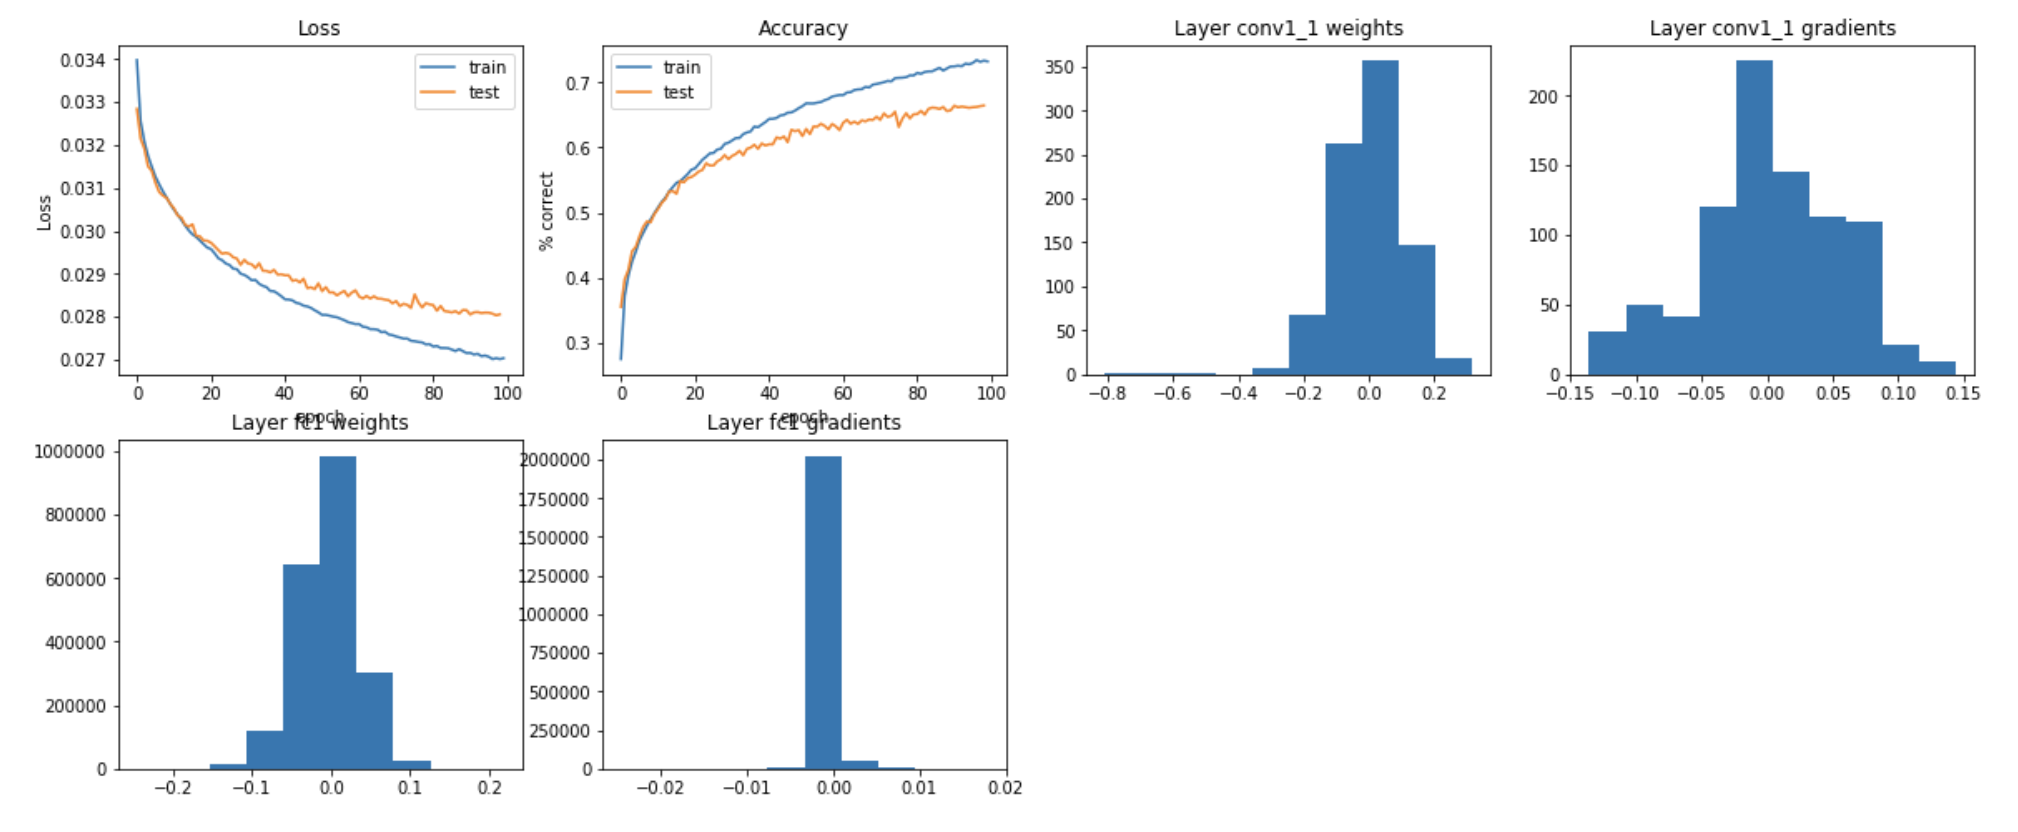

## [optional] : Transfer Learning example

Transfer learning is an extremely popular approach to getting world class classification results by using a previously trained network and adapting it to your problem.  Transfer learning works on the principle that patterns detected in one set of images are likely common to images in other domains.  Typically, you can download a pretrained model that was trained on ImageNet for example, and then just repurpose the network for your problem by swapping out the final classification layer with your custom layer. Below, we demonstrate this concept with [**resnet18**](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035).



In [ ]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)

xfer_model = resnet18


### Modify Pretrained Network for our 10 Class CIFAR example

Here we do two steps.  First we allow all the layers of the pre-trained model to be adjusted, and second we replace the last layer of the neural network with our new layer that tries to predict 1 out of 10 classes.

In [ ]:
## Drop last layer and bolt on my final layer
for param in xfer_model.parameters():
    param.requires_grad = True
    # Replace the last fully-connected layer
    # Parameters of newly constructed modules have requires_grad=True by default

xfer_model.fc = nn.Linear(512, 10) # assuming that the fc7 layer has 512 neurons, otherwise change it 
xfer_model.cuda()
model_summary(xfer_model)
#for param in xfer_model.parameters():
#    print(param.requires_grad)


### Setup Data Transformers
These transformers are recommend to use for Resnet18.  Resnet18 requires a 224x224x3 image, and also the images need to be RGB normalized with the mean and standard deviation presets below.

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
# see https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Setup Data Loaders

In [ ]:
batch_size = 32

# https://pytorch.org/docs/stable/data.html
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)


print('Number of Training samples: ', len(train_set))
print('Number of Test samples: ',     len(test_set))
print('Batch Size : ',                batch_size)
print('==>>> total training batches : {}'.format(len(train_loader)))
print('==>>> total testing batches : {}'.format(len(test_loader)))
#print('type {}'.format(type(train_fm_loader)))

### Visualize Transformers

In [ ]:
# Grab a batch of 64 images ...
image_tensor = get_batch(train_loader, 1)

# Plot using make_grid torchvision utility!
# https://pytorch.org/docs/stable/torchvision/utils.html
show(make_grid(image_tensor, nrow=8,padding=1, normalize=True, scale_each=False))

### Training Run

So for this training run, we load the pretrained model, and train on our data set.  This takes quite a bit longer to run, but you will see after the first few epochs how well the model performs.  **The moral of the story is use pretrained networks where it makes sense!**

In [ ]:
# reload_libs()
# Training run here ...
reset_weights=False

# Instantiate Model

# Enable GPU's
use_cuda = True
if use_cuda and reset_weights:
    xfer_model = xfer_model.to("cuda")

# create your optimizer
optimizer = optim.Adam(xfer_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

if(reset_weights) :
    xfer_model.apply(weights_xavier)  # comment out this line for round 2
    #model.apply(weights_xavier)         # uncomment this line for round 2

# in your training loop:

curves = {'train' : [], 'test' : []}

utils.viz_network(0,curves,xfer_model,use_cuda)


for epoch in range(15) :

    train_res = train_test(xfer_model, epoch, train_loader, batch_size, use_cuda, mode='train',debug=False)
    curves['train'].append(train_res)
    
    utils.viz_network(epoch,curves,xfer_model,use_cuda)
    
    test_res = train_test(xfer_model, epoch, test_loader,batch_size, use_cuda, mode='test',debug=False)
    curves['test'].append(test_res)

    #print(curves)
    #print("Epoch {} Train loss = {}".format(epoch, train_res))
    #print("Epoch {} Test loss = {}".format(epoch, test_res))
    
    print("**")
    print("Epoch:{} / Train loss: {} / Train Accuracy:{:.02f}".format(epoch, train_res,
                                                        100*float(train_res[1])/float(train_res[2])))
    print("Epoch:{} / Test loss : {} / Test  Accuracy:{:.02f}".format(epoch, test_res,
                                                        100*float(test_res[1])/float(test_res[2])))
